In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd


def load_data(l):
    data=np.array(pd.read_csv(l,delimiter=",",skiprows=1))
    X = data[:,1:]
    Y = data[:,0]
    return (X,Y)
def split(X,Y,s):
    m=X.shape[0]
    a=math.ceil(s*m)
    return(X[:a],Y[:a],X[a:],Y[a:])
def initialize(n, unit):
    W = np.random.randn(n, unit)
    b = np.zeros((1, unit))
    return W, b

def onehotencode(Y,units):
    unit=units[-1]
    m = Y.shape[0]
    Y_n = np.zeros((m,unit))
    for k in range(unit):
        Y_n[:,k] = np.where(Y == k, 1, 0)        
    return Y_n

def loss(y_n, z):
    m = y_n.shape[0]
    loss = (-1 / m) * np.sum(y_n * np.log(z + 1e-20))
    return loss

def forward_prop(X, layers, units, w_dict, b_dict):
    z_dict = {}
    for i in range(layers):
        z_dict[i] = X
        a = X @ w_dict[i] + b_dict[i]
        if i != layers - 1:
            X = np.maximum(0, a)  
        else:
            exp_z = np.exp(a - np.max(a, axis=1, keepdims=True))
            X = exp_z / np.sum(exp_z, axis=1, keepdims=True)  
    return X, z_dict

def backward_prop(X, Y, z, z_dict, w_dict, b_dict, layers, units):
    m, n = z.shape
    dz_dict, dw_dict, db_dict = {}, {}, {}
    Y_n = onehotencode(Y,units)
    for i in range(layers - 1, -1, -1):
        if i == (layers - 1):
            dz = z - Y_n  
        else:
            dz = (dz_dict[i + 1] @ w_dict[i + 1].T) * np.where(z_dict[i + 1] > 0, 1, 0)        
        dz_dict[i] = dz
        dw = (1 / m) * (z_dict[i].T @ dz)
        db = (1 / m) * np.sum(dz, axis=0)        
        dw_dict[i], db_dict[i] = dw, db    
    return dw_dict, db_dict , Y_n

def fit(X, Y, layers, units, alpha, steps):
    w_dict, b_dict = {}, {}
    for i in range(layers):
        w_dict[i], b_dict[i] = initialize(X.shape[1] if i == 0 else units[i-1], units[i])    
    loss_list, i_list = [],[]
    for i in range(steps + 1):
        i_list.append(i)
        z, z_dict = forward_prop(X, layers, units, w_dict, b_dict)
        dw_dict, db_dict, Y_n = backward_prop(X, Y, z, z_dict, w_dict, b_dict, layers, units)        
        for k in range(layers):
            w_dict[k] -= alpha * dw_dict[k]
            b_dict[k] -= alpha * db_dict[k]        
        cst = loss(Y_n, z)
        loss_list.append(cst)        
        if i % math.ceil(steps / 10) == 0:
            print(f"Iteration {i:9d}, Cost: {cst}")    
    return w_dict, b_dict, loss_list, i_list

def predict(X, w_dict, b_dict, layers):
    for i in range(layers):
        m, n = X.shape
        a = X @ w_dict[i] + b_dict[i]
        if i != layers - 1:
            z = np.maximum(0, a)
        else:
            exp_z = np.exp(a - np.max(a, axis=1, keepdims=True))
            z = exp_z / np.sum(exp_z, axis=1, keepdims=True)  
        X = z
    predictions = np.argmax(X, axis=1)
    return predictions

def f1_score(classes, y_train,y_predicted):
    con_matrix = np.zeros((classes,classes),dtype=int)
    for i, k in zip(y_train, y_predicted):
        con_matrix[int(i),int(k)] += 1
    df = pd.DataFrame(con_matrix)
    precision = np.zeros(classes)
    recall = np.zeros(classes)
    f1 = np.zeros(classes)
    for i in range(classes):
        t_p = con_matrix[i, i]
        f_p = np.sum(con_matrix[:, i]) - t_p
        f_n = np.sum(con_matrix[i, :]) - t_p
        precision[i] = t_p / (t_p + f_p) if (t_p + f_p) != 0 else 0
        recall[i] = t_p / (t_p + f_n) if (t_p + f_n) != 0 else 0
        f1[i] = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i]) if (precision[i] + recall[i]) != 0 else 0
    f1score = np.mean(f1)
    return f1score, df

def plot(cost,i_list):
    plt.plot(i_list,cost,c="r",label="cost")
    plt.xlabel(f"iteration")
    plt.ylabel("cost")
    plt.legend()
    plt.show()

In [2]:
X,Y = load_data("Classification_train.csv")
X_new= X/255
X_train,Y_train,X_cv,Y_cv = split(X_new,Y,0.83)

In [3]:
units = [128, 10]
alpha = 1
layers = 2
steps = 10000
print(f"units = {[128, 10]} alpha = {1} layers = {2} steps = {10000}")
w, b, loss_list, _ = fit(X_train, Y_train, layers, units, alpha, steps)
y_pred = predict(X_cv, w, b, layers)

units = [128, 10] alpha = 1 layers = 2 steps = 10000
Iteration         0, Cost: 37.140011465594846
Iteration      1000, Cost: 0.052788596638572674
Iteration      2000, Cost: 0.018830931161895624
Iteration      3000, Cost: 0.008525655817449329
Iteration      4000, Cost: 0.0044266216276174246
Iteration      5000, Cost: 0.0027200824036308054
Iteration      6000, Cost: 0.0018855351912992117
Iteration      7000, Cost: 0.001409588122764899
Iteration      8000, Cost: 0.0011151847090566786
Iteration      9000, Cost: 0.0009155935061359194
Iteration     10000, Cost: 0.0007726137471864329


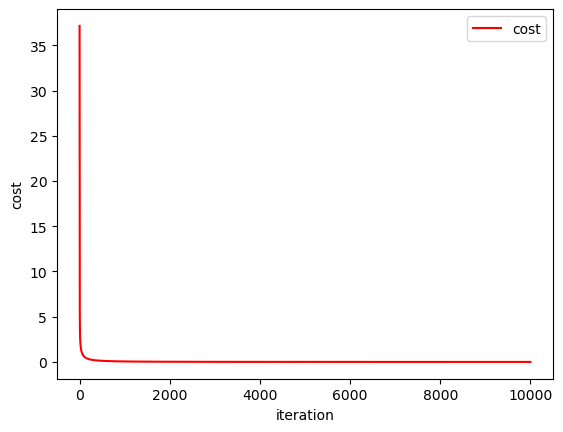

In [4]:
plot(loss_list,_)

In [6]:
accuracy = np.mean(y_pred == Y_cv)
f1, confusion_matrix = f1_score(units[-1], Y_cv, y_pred)
print(f"Accuracy: {accuracy*100:.7f}%, F1 Score: {f1:.2f}")
print()
print("confusion_matrix")
confusion_matrix

Accuracy: 95.9403805%, F1 Score: 0.96

confusion_matrix


,0,1,2,3,4,5,6,7,8,9
0,468,13,4,1,0,0,0,3,2,0
1,13,488,2,0,0,0,2,1,1,1
2,1,0,511,1,0,1,0,0,1,0
3,2,0,2,494,4,2,1,10,0,2
4,1,0,0,4,498,5,1,5,0,5
5,0,1,4,4,4,509,0,1,6,0
6,0,2,0,2,0,0,489,17,0,7
7,0,0,0,11,0,0,18,473,0,3
8,4,1,1,3,1,2,1,0,467,1
9,2,3,0,1,8,1,2,3,2,495


# Load test data

In [7]:
#testing
X_test,Y_id=load_data("Classification_test.csv")
X=X_test/255
p_test = predict(X_test, w, b,layers)
np.savetxt('neural_test_prediction.csv', p_test, delimiter=',', header='Test target', comments='')